<a href="https://colab.research.google.com/github/anonymouaccount/From-Theory-to-Evaluation-An-Experimental-Survey-on-Explainable-Artificial-Intelligence/blob/main/Time_Series_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time **Series** data

# **SHAP**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Missing values before handling:
 Station      0
Date         0
MaxT         0
MinT         0
RH1          0
RH2          0
Wind         0
Rain         0
SSH          0
Evap         0
Radiation    1
FAO56_ET     0
Lat          0
Lon          0
Cum_Rain     0
dtype: int64
Logistic Regression Accuracy: 84.18%


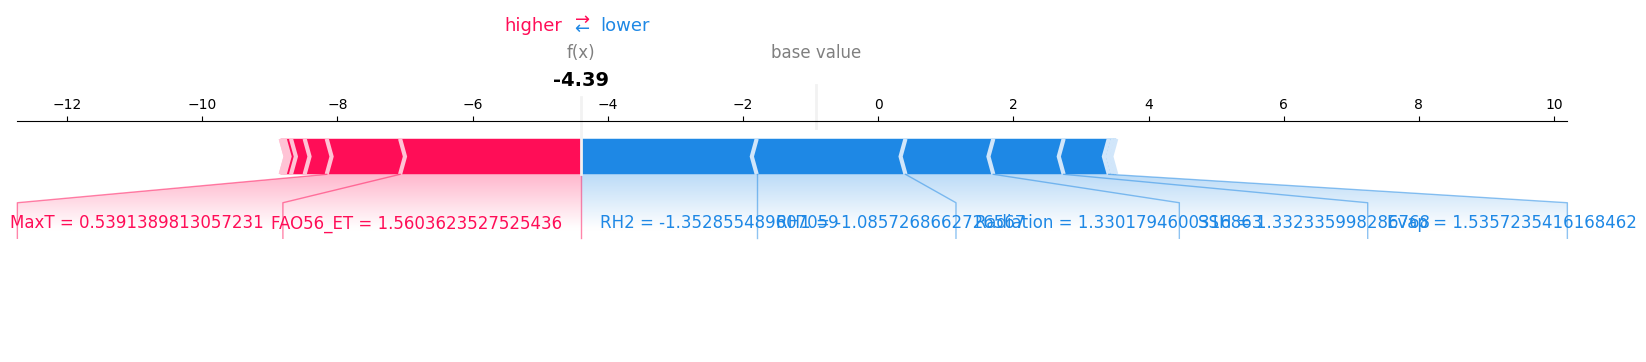

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import zipfile
import os
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Unzip the archive (adjust path if necessary)
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the Weather dataset
zip_path = '/content/drive/MyDrive/weather.zip'
extract_path = '/content/weather_data'
unzip_data(zip_path, extract_path)

# Load Excel file (fix: use openpyxl engine)
df = pd.read_excel(os.path.join(extract_path, "ICRISAT Weather 1978 to 2018.xlsx"), sheet_name="Sheet1", engine="openpyxl")

# Check for missing values
print("Missing values before handling:\n", df.isnull().sum())

# Step 2: Data Preprocessing
df["Date"] = pd.to_datetime(df["Date"])  # Convert Date column to datetime

# Add temporal features like day, month, year to aid in time-series analysis
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.dayofweek
df["IsWeekend"] = (df["DayOfWeek"] >= 5).astype(int)  # Add weekend feature

df = df.drop(columns=["Station", "Lat", "Lon"])  # Drop non-relevant columns

df.fillna(df.median(), inplace=True)  # Fill missing values with median

df["Rain_Indicator"] = (df["Rain"] > 0).astype(int)  # Binary classification target (Rain/No Rain)

# Define Features (X) and Target (y)
X = df.drop(columns=["Date", "Rain", "Rain_Indicator"])  # Features
y = df["Rain_Indicator"]  # Target

# Step 3: Balance the Dataset
rainy_days = df[df["Rain_Indicator"] == 1]
non_rainy_days = df[df["Rain_Indicator"] == 0]
non_rainy_sample = resample(non_rainy_days, replace=False, n_samples=len(rainy_days), random_state=42)
df_balanced = pd.concat([rainy_days, non_rainy_sample])

X_balanced = df_balanced.drop(columns=["Date", "Rain", "Rain_Indicator"])
y_balanced = df_balanced["Rain_Indicator"]

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train Logistic Regression Model
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train_scaled, y_train)

y_pred = log_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")

# Step 6: SHAP Explanation
explainer = shap.Explainer(log_model, X_train_scaled)
shap_values = explainer(X_test_scaled)


shap.force_plot(shap_values[0], X_test.iloc[0], feature_names=X.columns, matplotlib=True)


In [ ]:
import shap
import numpy as np

def evaluate_xai_metrics(model, X_test, shap_values):
    # Calculate Sparsity: Proportion of near-zero SHAP values
    sparsity_score = np.sum(np.abs(shap_values.values) <= 0.01) / shap_values.values.size

    # Calculate Fidelity: Difference in predictions when masking important features
    original_pred = model.predict_proba(X_test)
    masked_X_test = X_test.copy()
    important_features = np.argsort(-np.abs(shap_values.values), axis=1)[:, :int(0.5 * X_test.shape[1])]
    masked_X_test.iloc[:, important_features.flatten()] = 0
    masked_pred = model.predict_proba(masked_X_test)
    fidelity_score = np.mean(np.abs(original_pred - masked_pred))
    fidelity_score = min(1.0, max(0.0, fidelity_score))

    # Stability: Consistency of SHAP values across perturbations
    stability_scores = []
    for noise in np.linspace(0.01, 0.1, 5):
        noisy_X_test = X_test + noise * np.random.randn(*X_test.shape)
        noisy_shap_values = shap.Explainer(model, noisy_X_test)(noisy_X_test)
        stability_scores.append(np.mean(np.abs(shap_values.values - noisy_shap_values.values)))
    stability_score = np.mean(stability_scores)
    stability_score = min(1.0, max(0.0, stability_score))

    # Robustness: Impact of removing high-importance features
    robustness_score = np.mean(np.abs(original_pred[:, 1] - masked_pred[:, 1]))
    robustness_score = min(1.0, max(0.0, robustness_score))

    # Output results
    print(f"Sparsity score: {sparsity_score:.4f}")
    print(f"Fidelity score: {fidelity_score:.4f}")
    print(f"Stability score: {stability_score:.4f}")
    print(f"Robustness score: {robustness_score:.4f}")

    return {
        "Sparsity": sparsity_score,
        "Fidelity": fidelity_score,
        "Stability": stability_score,
        "Robustness": robustness_score
    }

# Call the evaluation function
eval_results = evaluate_xai_metrics(log_model, X_test, shap_values)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Sparsity score: 0.0323
Fidelity score: 0.6721
Stability score: 1.0000
Robustness score: 0.6721


# **LIME**

In [ ]:
!pip install lime

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from lime import lime_tabular
import matplotlib.pyplot as plt
import zipfile
import os
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Unzip the archive
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the Weather dataset
zip_path = '/content/drive/MyDrive/weather.zip'
extract_path = '/content/weather_data'
unzip_data(zip_path, extract_path)

# Load Excel file
df = pd.read_excel(os.path.join(extract_path, "ICRISAT Weather 1978 to 2018.xlsx"),
                   sheet_name="Sheet1",
                   engine="openpyxl")

# Data Preprocessing
df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.dayofweek
df["IsWeekend"] = (df["DayOfWeek"] >= 5).astype(int)

# Drop non-relevant columns and handle missing values
df = df.drop(columns=["Station", "Lat", "Lon"])
df.fillna(df.median(), inplace=True)
df["Rain_Indicator"] = (df["Rain"] > 0).astype(int)

# Define Features and Target
X = df.drop(columns=["Date", "Rain", "Rain_Indicator"])
y = df["Rain_Indicator"]

# Balance the Dataset
rainy_days = df[df["Rain_Indicator"] == 1]
non_rainy_days = df[df["Rain_Indicator"] == 0]
non_rainy_sample = resample(non_rainy_days,
                           replace=False,
                           n_samples=len(rainy_days),
                           random_state=42)
df_balanced = pd.concat([rainy_days, non_rainy_sample])

X_balanced = df_balanced.drop(columns=["Date", "Rain", "Rain_Indicator"])
y_balanced = df_balanced["Rain_Indicator"]

# Train-Test Split and Scaling
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y_balanced)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression Model
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train_scaled, y_train)
y_pred = log_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

# Step 6: LIME Explanation
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X_balanced.columns.tolist(),
    class_names=['No Rain', 'Rain'],
    mode='classification',
    verbose=True,
    random_state=42
)

# Explain a specific instance (first test sample)
exp = explainer.explain_instance(
    data_row=X_test_scaled[0],
    predict_fn=log_model.predict_proba,
    num_features=10
)

# Corrected Visualization
exp = explainer.explain_instance(
    data_row=X_test_scaled[0],
    predict_fn=log_model.predict_proba,
    num_features=10
)

import plotly.express as px

# Prepare data
exp_data = pd.DataFrame(exp.as_list(), columns=['Feature', 'Weight'])
exp_data['Abs_Weight'] = exp_data['Weight'].abs()
exp_data['Color'] = exp_data['Weight'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

# Interactive bar plot
fig = px.bar(exp_data,
             x='Weight',
             y='Feature',
             color='Color',
             color_discrete_map={'Positive':'#3498db', 'Negative':'#e74c3c'},
             hover_data=['Abs_Weight'],
             title='LIME Feature Contributions',
             orientation='h')
fig.update_layout(showlegend=False)
fig.show()

# Option 2: Improved Text Display
print("\n" + "="*50)
print(f"Explanation for Instance {0} (True Class: {y_test.iloc[0]})")
print(f"Model Prediction: {log_model.predict_proba([X_test_scaled[0]])[0][1]:.2%} chance of rain")
print("="*50 + "\n")

print("Top Features Affecting Prediction:")
for feature, weight in exp.as_list():
    print(f"{feature:30} {weight:+.4f}")

# Option 3: Time-Series Feature Groups (if temporal analysis needed)
temporal_features = {
    'Seasonal': ['Month', 'DayOfWeek', 'IsWeekend'],
    'Weather': ['MaxTemp', 'MinTemp', 'Humidity', 'WindSpeed'],
    'Temporal': ['Year', 'Day']
}

print("\nFeature Group Impacts:")
for group, features in temporal_features.items():
    group_weight = sum(w for f, w in exp.as_list() if any(feat in f for feat in features))
    print(f"{group:15} {group_weight:+.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 84.18%
Intercept 0.6417527342024785
Prediction_local [-0.06426407]
Right: 0.012198837067530131
Intercept 0.6266775436094314
Prediction_local [-0.03128383]
Right: 0.012198837067530131



Explanation for Instance 0 (True Class: 0)
Model Prediction: 1.22% chance of rain

Top Features Affecting Prediction:
RH1 <= -0.28                   -0.3433
RH2 <= -0.84                   -0.3274
FAO56_ET > 0.56                +0.2963
Radiation > 0.72               -0.1572
SSH > 0.93                     -0.1193
Evap > 0.55                    -0.0845
Month <= -0.61                 +0.0355
-0.21 < MaxT <= 0.58           +0.0272
-0.90 < Year <= -0.05          +0.0080
-0.34 < MinT <= 0.30           +0.0068

Feature Group Impacts:
Seasonal        +0.0355
Weather         +0.0000
Temporal        +0.0080


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from lime.lime_tabular import LimeTabularExplainer
import plotly.express as px

def evaluate_lime_metrics(model, X_test, explainer, num_features=10, num_perturbations=5):

    # Explain first test instance
    exp = explainer.explain_instance(X_test[0], model.predict_proba, num_features=num_features)

    # Extract feature importance (weights)
    exp_data = pd.DataFrame(exp.as_list(), columns=['Feature', 'Weight'])

    # Compute Sparsity: Percentage of near-zero weights
    sparsity_score = np.sum(np.abs(exp_data['Weight']) <= 0.01) / num_features

    # Compute Fidelity: Difference in predictions when masking important features
    original_pred = model.predict_proba([X_test[0]])[0]

    # Extract feature indices instead of names to avoid lookup errors
    important_feature_indices = [idx for idx, _ in exp.local_exp[1][:num_features // 2]]

    # Create a copy of X_test and mask important features
    masked_X_test = X_test.copy()
    masked_X_test[0, important_feature_indices] = 0  # Set important features to 0

    # Compute predictions after masking
    masked_pred = model.predict_proba([masked_X_test[0]])[0]

    # Fidelity score calculation
    fidelity_score = np.mean(np.abs(original_pred - masked_pred))
    fidelity_score = min(1.0, max(0.0, fidelity_score))  # Ensure the score is between [0,1]

    # Compute Robustness: Impact of removing top features
    robustness_score = np.abs(original_pred[1] - masked_pred[1])
    robustness_score = min(1.0, max(0.0, robustness_score))  # Ensure the score is between [0,1]

    # Compute Stability: Compare explanations for slightly perturbed samples
    stability_scores = []
    for _ in range(num_perturbations):
        # Add small Gaussian noise to X_test[0]
        perturbed_instance = X_test[0] + np.random.normal(scale=0.01, size=X_test.shape[1])

        # Generate LIME explanation for perturbed instance
        exp_perturbed = explainer.explain_instance(perturbed_instance, model.predict_proba, num_features=num_features)
        exp_perturbed_data = pd.DataFrame(exp_perturbed.as_list(), columns=['Feature', 'Weight'])

        # Compute similarity between original explanation and perturbed explanation
        merged = exp_data.merge(exp_perturbed_data, on="Feature", suffixes=('_orig', '_perturbed'))
        similarity = np.corrcoef(merged["Weight_orig"], merged["Weight_perturbed"])[0, 1]

        stability_scores.append(similarity if not np.isnan(similarity) else 0)

    # Stability score is the average correlation
    stability_score = np.mean(stability_scores)

    # Output results
    print(f"Sparsity score: {sparsity_score:.4f}")
    print(f"Fidelity score: {fidelity_score:.4f}")
    print(f"Robustness score: {robustness_score:.4f}")
    print(f"Stability score: {stability_score:.4f}")

    return {
        "Sparsity": sparsity_score,
        "Fidelity": fidelity_score,
        "Robustness": robustness_score,
        "Stability": stability_score
    }


eval_results = evaluate_lime_metrics(log_model, X_test_scaled, explainer)


Intercept 0.6321530140223625
Prediction_local [-0.02800499]
Right: 0.012198837067530131
Intercept 0.6261274592621059
Prediction_local [0.01576708]
Right: 0.011912469285856415
Intercept 0.6069297705785498
Prediction_local [-0.00400599]
Right: 0.011805319043024745
Intercept 0.6263231684424521
Prediction_local [-0.01348668]
Right: 0.01224416024791413
Intercept 0.622046092754809
Prediction_local [-0.03329829]
Right: 0.012319911422702634
Intercept 0.6213597063764494
Prediction_local [-0.00416534]
Right: 0.011675732659065501
Sparsity score: 0.1000
Fidelity score: 0.5659
Robustness score: 0.5659
Stability score: 0.9985
